In [2]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup

imp.reload(sp)

mbins = 1000

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [6]:
# load in redshift data
lensFile = '/home/b7009348/WGL_project/LSST-SRD-data/DL-validation-covs/dNdz_clust_LSSTSRD_Y1_zb0_sigz0.03.dat'
lensZdat = np.loadtxt(lensFile)
z_len = lensZdat[:,0]
sourceFile = '/home/b7009348/WGL_project/LSST-SRD-data/DL-validation-covs/dNdz_srcs_LSSTSRD_Y1_zb0_sigz0.05.dat'
sourceZdat = np.loadtxt(sourceFile)
z_src = sourceZdat[:,0]

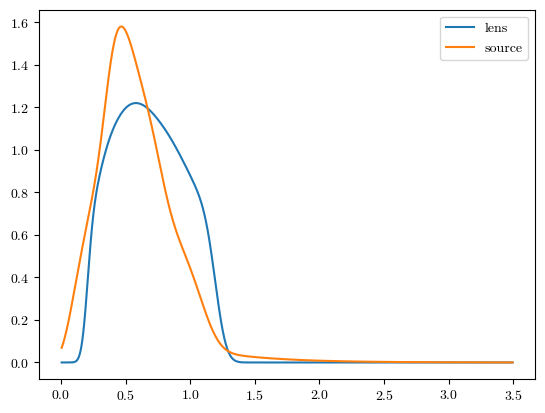

In [21]:
# sum distributions and renormalise
src_dndz = 0.
len_dndz = 0.
for i in range(len(lensZdat[0,:])-1):
    src_dndz = src_dndz + sourceZdat[:,i+1]
    len_dndz = len_dndz + lensZdat[:,i+1]
    
# normalise functions
len_dndz = len_dndz/scipy.integrate.simps(len_dndz,z_len)
src_dndz = src_dndz/scipy.integrate.simps(src_dndz,z_src)
    
plt.plot(z_len, len_dndz)
plt.plot(z_src, src_dndz)
plt.legend(['lens','source'])

### Most significant affect on lensing tracer comes from shifted mean of z-distribution

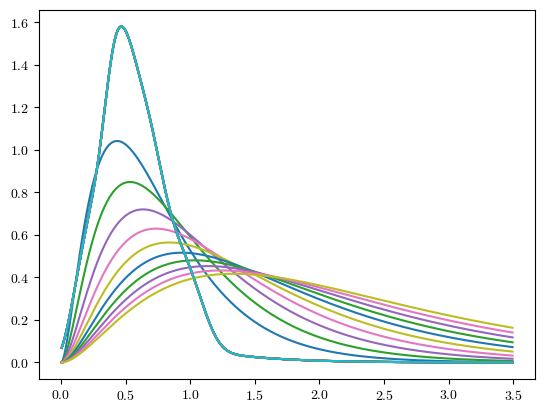

In [152]:
z0_vec = np.linspace(0.13,0.4,10)

for i in range(len(z0_vec)):
    dndz_shift = z_src**2 * np.exp(-(z_src/z0_vec[i])**0.78)
    norm = scipy.integrate.simps(dndz_shift, z_src)
    dndz_shift = dndz_shift/norm

    plt.plot(z_src, dndz_shift)
    plt.plot(z_src, src_dndz)

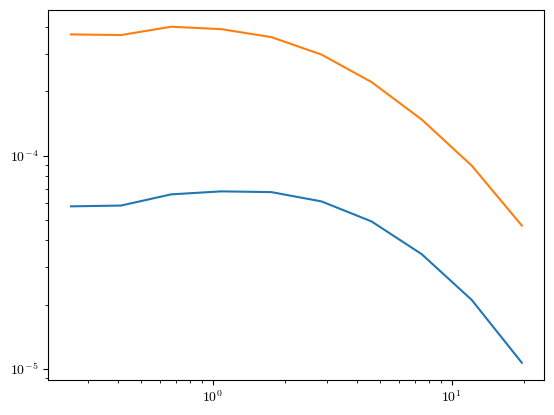

In [148]:
A_IA = 0.16 * 5. * np.ones(len(z_len))

lensTracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_len, len_dndz), 
                                    bias=(z_len, sp.lens_bias(z_len)))
shearTracer1 = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_src, src_dndz), has_shear=True,
                                   ia_bias=(z_src, A_IA))
shearTracer2 = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_src, dndz_shift), has_shear=True,
                                   ia_bias=(z_src, A_IA))

theta = sp.theta_cents #forecasts

ell = np.unique(np.geomspace(180/(th_lsst[-1]/60.) - 10, 180/(th_lsst[0]/60.) + 10, 1024).astype(int))

Cl_1 = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, shearTracer1, ell)

xi1 = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_1, th_lsst/60., type='NG')

Cl_2 = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, shearTracer2, ell)

xi2 = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_2, th_lsst/60., type='NG')

plt.loglog(theta, xi2)
plt.loglog(theta, xi1)